In [1]:
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import json
from sklearn import preprocessing
from random import *

from lib import audio_methods
from lib import formatter
from lib import base

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

# Data Exploration

## Reading in Data

Our dataframe has all the playlists in the first raw dataset. Our first goal is to create the user-item matrix, or in our case a playlist-track matrix. We assume each playlist an an unique user, and each track is an item. So we need to extract all the track IDs from each playlist first.

"Name", "Collaborative", "Modified_at", and "Num_edits" are deleted because we are not interested in metadata.

In [2]:
df = pd.DataFrame.from_dict(formatter.import_to_json("raw_data/p1.json"))
df = df.drop(['name','collaborative','modified_at','num_edits'],axis=1)

all_tracks = []
for i in range(0,1000):
    pl = df['tracks'][i]
    for j in range(0,len(pl)):
        all_tracks.append(pl[j]['track_uri'])
        
all_tracks = list(dict.fromkeys(all_tracks))
len(all_tracks)

34443

There are 34443 unique tracks in dataset 1.

# Constructing User-Item Matrix

Recommender systems use matrices to contain information about their items and/or users. A user-item matrix reveals which users have interactions with which items; a user-user matrix with users; and likewise with item-item matrices. We will be constructing a user-item matrix to start with.

A "1" means the track exists and "0" means it doesn't.

In [3]:
##################################################
##         WARNING: *MAY* TAKE FOREVER          ##
##        Depending on system resources.        ##
##    Otherwise, run the next block instead.    ##           
##################################################

n = 1000 # number of playlists
user_item_matrix = pd.DataFrame(index=all_tracks,columns=range(0,n))

temp_pl = df['tracks'].tolist()
for i in range(0,n):
    temp_pl_i = temp_pl[i]
    temp_pl_i_len = len(temp_pl_i)
    for j in range(0,temp_pl_i_len):
        track_uri = temp_pl_i[j]['track_uri']
        user_item_matrix.loc[track_uri,i] = 1

        user_item_matrix.fillna(0,inplace=True)
user_item_matrix.to_csv("./data_frames/user_item_matrix.csv")
user_item_matrix

KeyboardInterrupt: 

In [4]:
#########################################
##  Only run if data already exists    ##         
#########################################

user_item_matrix = pd.read_csv("./data_frames/user_item_matrix.csv", usecols=range(0,1001),index_col=0)
user_item_matrix

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:6I9VzXrHxO9rA9A5euc8Ak,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:0WqIKmW4BTrj3eJFmnCKMv,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:1AWQoqb9bSvzTjaLralEkT,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spotify:track:1lzr43nnXAijIGYnCT8M8H,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:3uCHI1gfOUL5j5swEh0TcH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
spotify:track:0P1oO2gREMYUCoOkzYAyFu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
spotify:track:2oM4BuruDnEvk59IvIXCwn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Visualize frequency of tracks

In practice, users rarely interact with most items. So recommender systems often run into sparse matrix issue; where most of the data is zeros or nulls. See below, approximately 25,000 of the 34,000 tracks occur only once.

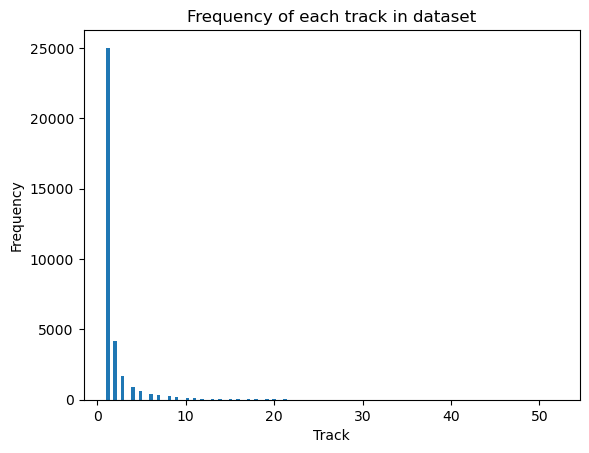

In [4]:
track_freq = user_item_matrix.sum(axis=1)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         }
plt.rcParams.update(params)
plt.style.use("default")
plt.hist(track_freq,bins=125,label="Unique tracks")
plt.gca().set(title = "Frequency of each track in dataset",
              ylabel = "Frequency",
              xlabel = "Track");

## Obtain Audio Features of Each Track

Use Spotify API to gather information on the following features of a track:
* danceability

* energy

* key

* loudness

* mode

* speechiness

* acousticness

* instrumentalness

* liveness

* valence

* tempo

In [ ]:
##################################################
##         WARNING: THIS TAKES FOREVER          ##
##    ONLY run if data doesn't already exist.   ##
##    Otherwise, run the next block instead.    ##           
##################################################

feature_stats = pd.DataFrame(data=None, columns=['danceability','energy','key','loudness','mode',
                                                 'speechiness','acousticness','instrumentalness',
                                                 'liveness','valence','tempo'])
for i in range(0,len(all_tracks)):    
    try:
        feats = audio_methods.getAudioFeatures(all_tracks[i])
        add_new = {
            'danceability':feats['danceability'],
            'energy':feats['energy'],
            'key':feats['key'],
            'loudness':feats['loudness'],
            'mode':feats['mode'],
            'speechiness':feats['speechiness'],
            'acousticness':feats['acousticness'],
            'instrumentalness':feats['instrumentalness'],
            'liveness':feats['liveness'],
            'valence':feats['valence'],
            'tempo':feats['tempo']
        }
        feature_stats = feature_stats.append(add_new,ignore_index=True)
    except:
        print("This had issues: ",all_tracks[i]," at ",str(i))
        add_new = {
            'danceability':-199,
            'energy':-199,
            'key':-199,
            'loudness':-199,
            'mode':-199,
            'speechiness':-199,
            'acousticness':-199,
            'instrumentalness':-199,
            'liveness':-199,
            'valence':-199,
            'tempo':-199
        }
        feature_stats = feature_stats.append(add_new,ignore_index=True)

# Export data to csv, to save time next run.
feature_stats.to_csv("./data_frames/feature_stats.csv")

In [5]:
######################################
## Only run if data already exists  ##
######################################

feature_stats = pd.read_csv("./data_frames/feature_stats.csv",usecols = range(1,12))
feature_stats.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000
mean,0.578946,0.630797,5.207299,-7.613708,0.659408,0.085500,0.257960,0.071164,0.191722,0.480304,121.675926
std,1.087887,1.099056,3.748348,4.095125,1.174803,1.077521,1.114951,1.094688,1.086309,1.102140,29.356377
min,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000,-199.000000
25%,0.476000,0.490000,2.000000,-9.170000,0.000000,0.035100,0.020200,0.000000,0.095800,0.292000,98.555500
50%,0.592000,0.669000,5.000000,-6.698000,1.000000,0.048900,0.126000,0.000008,0.128000,0.477000,120.858000
75%,0.705000,0.818000,8.000000,-5.004000,1.000000,0.095950,0.445000,0.002680,0.252000,0.677000,140.030500
max,0.988000,1.000000,11.000000,2.766000,1.000000,0.962000,0.996000,0.995000,1.000000,0.998000,219.297000


## Data Cleaning

Clearly there is something wrong with one of the datapoints (note the mins of each column). That -199 means the try-catch caught something when calling Spotipy. We remove datapoint(s) with errors using the following code.

In [6]:
try:
    print("The following indices had issues:")
    null_indices = feature_stats.loc[feature_stats['energy'] == -199].index[0]
    del all_tracks[-null_indices]
    feature_stats = feature_stats.drop(axis=0,index=null_indices)
    print(null_indices)
    del null_indices
    feature_stats.describe()
except:
    print("No nulls found / nulls are cleaned up")

The following indices had issues:
15933


Track 15933 was the culprit. Now the basic statistics looks managable.

# Data Preparation

K-Means clustering requires all datapoints to have equal variance. We address this by normalizing each column so they have mean of 0 and variance of 1.

"Key" and "Mode" are categorical variable that lose their meanings once normalized. An option is to hot encode them, however, we will be deleting them from our dataset instead. Normalization will still affect post-hot encoding variables.

In [7]:
normalized_feature_stats = feature_stats.drop(columns=['key','mode'])
normalized_feature_stats = (normalized_feature_stats-normalized_feature_stats.mean())/normalized_feature_stats.std()
normalized_feature_stats.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,34442.00000,34442.00000,34442.00000,34442.00000,34442.00000,34442.00000,34442.00000,34442.00000,34442.00000
mean,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-3.56007,-2.82434,-13.21957,-0.90196,-0.87762,-0.35230,-1.17971,-1.99555,-4.15224
25%,-0.66205,-0.65038,-0.39409,-0.55513,-0.81040,-0.35230,-0.60749,-0.79681,-0.78921
50%,0.04419,0.14378,0.22965,-0.41877,-0.45835,-0.35227,-0.41516,-0.03734,-0.02821
75%,0.73217,0.80484,0.65708,0.04639,0.60313,-0.34003,0.32550,0.78371,0.62600
max,2.45515,1.61231,2.61762,8.60372,2.43659,4.20353,4.79334,2.10150,3.33079


In [11]:
normalized_feature_stats['track'] = all_tracks
normalized_feature_stats = normalized_feature_stats.set_index('track')
normalized_feature_stats.to_csv('./lib/normalized_feature_stats.csv')

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track,,,,,,,,,
spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,1.943738,0.782658,0.126956,0.293665,-0.774129,-0.320391,-0.898376,1.329710,0.128840
spotify:track:6I9VzXrHxO9rA9A5euc8Ak,1.152261,0.893574,0.932112,0.224497,-0.794760,-0.237836,0.265771,1.797710,0.728685
spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0.482550,0.538642,0.258667,1.173088,-0.869696,-0.352305,-0.822518,0.882237,-0.765246
spotify:track:1AWQoqb9bSvzTjaLralEkT,1.864590,0.343429,0.391893,0.481407,-0.205457,-0.351233,-0.868511,1.362552,-0.706794
spotify:track:1lzr43nnXAijIGYnCT8M8H,1.633235,-0.135729,0.760029,-0.197429,-0.690941,-0.352305,0.689857,0.689290,-0.918799
...,...,...,...,...,...,...,...,...,...
spotify:track:3uCHI1gfOUL5j5swEh0TcH,0.512992,-1.812783,-1.138182,-0.220155,1.757777,-0.054687,-0.615851,-0.345234,-1.319230
spotify:track:0P1oO2gREMYUCoOkzYAyFu,-0.558545,0.401106,0.650270,1.242256,-0.587123,-0.352305,-0.409184,-0.809129,-1.652440
spotify:track:2oM4BuruDnEvk59IvIXCwn,0.713905,-0.499534,-0.782662,-0.118379,0.227120,-0.099101,0.600262,-0.907655,0.627988


# Data Modeling

K-Means Clustering is an unsupervised learning method, which makes it harder to cross validate. There isn't a "correct" label that any cluster or record belongs. We continue to train the model, then validate by observing cluster separation and cohesion.

Basic Framework:

1. Principal Component Analysis to reduce dimensionality

2. Repeat K-Means Clustering for multiple Ks

3. Compare Separation and Cohesion Metrics to find optimal K

## Principal Component Analysis

Text(0.5, 1.0, 'Variance explained by number of components')

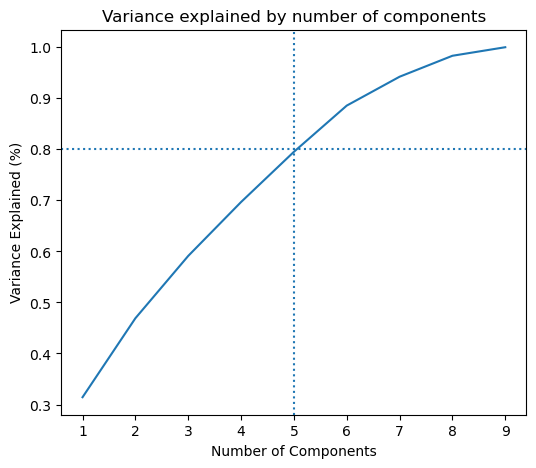

In [9]:
pca = PCA()
train_t = pca.fit(normalized_feature_stats)
plt.figure(figsize=(6,5))
plt.plot(range(1,10),train_t.explained_variance_ratio_.cumsum())
plt.axvline(x=5,linestyle='dotted')
plt.axhline(y=0.8,linestyle='dotted')

plt.xlabel("Number of Components")
plt.ylabel("Variance Explained (%)")
plt.title("Variance explained by number of components")

We typically aim for around 80-90% of variance explained. Therefore, 5 components are sufficient enough to describe the data's variance. The 5 components are as follows:

In [10]:
pca = PCA(n_components=5)
train_pca = pca.fit_transform(normalized_feature_stats)
attributes = ['danceability','energy','loudness','speechness','acousticness',
               'instrumentalness','liveness','valence','tempo']
PC_cols = ['PC1','PC2','PC3','PC4','PC5']
temp = pd.DataFrame(pca.components_,columns=attributes)
temp = temp.rename(index={0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5'})
temp

,danceability,energy,loudness,speechness,acousticness,instrumentalness,liveness,valence,tempo
PC1,-0.242478,-0.518602,-0.506015,-0.129862,0.468243,0.253460,-0.093979,-0.299849,-0.130793
PC2,0.638425,-0.236264,-0.162139,0.250138,0.186233,-0.195441,-0.235850,0.421365,-0.376405
PC3,-0.066638,-0.066236,-0.108782,0.667409,0.147361,-0.157772,0.691617,-0.079477,0.051434
PC4,-0.035981,0.100479,0.121475,-0.321223,-0.094297,-0.007587,0.400354,-0.128729,-0.827566
PC5,0.156113,0.164308,-0.144209,0.055038,-0.082278,0.870099,0.208826,0.341997,0.019855


PC1 correlates well with energy, loudness, and acousticness - so these variables are the source of most of the variance. The more acousticness of a track, the less energy and loudness the track has and vice versa.

PC2 has strong danceability and somewhat strong valence correlations, both with positive. These are the source of the second most varied variables.

PC3 corresponds with speechness and liveness (0.66 and 0.69, respectively).

PC4 negatively correlates with tempo,

PC5 positively correlates with instrumentalness.

We can fit our data using these principal components (also called eigenvectors). We can interpret the new matrix as "Track 0 can be described by 5 components (-1.75,1.75,-0.78,-0.63,0.48)".

In [11]:
train_pca = pd.DataFrame(train_pca,columns=PC_cols)
train_pca

,PC1,PC2,PC3,PC4,PC5
0,-1.754399,1.751019,-0.783098,-0.632242,0.484527
1,-2.335371,0.748540,-0.088715,-0.561861,0.747871
2,-1.263251,1.192971,-0.063963,-0.033535,0.070880
3,-1.310766,2.241533,-0.588520,-0.055770,0.299381
4,-1.248747,1.315912,0.014555,1.098989,0.224060
...,...,...,...,...,...
34437,2.563398,1.719664,-0.135926,0.456149,-0.530828
34438,-0.429961,0.091013,0.434390,1.106230,-0.699905
34439,0.712204,-0.027652,0.560340,-0.316136,-0.141787
34440,2.229300,0.298581,0.460838,-0.536680,-0.797634


## K-Means Clustering

We continue onto modeling K-means using 5 components. There are 15 clusters tested with K equal to 50,100,150,...,1500. For each model, we evaluate its cohesion and separation by measuring its Silhouette and Dunn's index.

In [ ]:
##################################################
##         WARNING: THIS TAKES FOREVER          ##
##    ONLY run if data doesn't already exist.   ##
##    Otherwise, run the next block instead.    ##
##################################################

SEED = 5523
kmeans_inertia = []
silhouette = []
dunn = []
k_values = range(50,1550,50)

for k in k_values:
    print("K: ",k)
    
    # Generate model
    temp = KMeans(n_clusters=k,random_state=SEED).fit(train_pca)
    # Obtain Silhouette score
    sil = metrics.silhouette_score(train_pca,temp.labels_,metric='euclidean')
    # Obtain Dunn's index
    dun = base.dunn_fast(train_pca,temp.labels_)

    # Add to arrays
    kmeans_inertia.append(round(temp.inertia_))
    silhouette.append(round(sil,4))
    dunn.append(round(dun,4))

eval_matrix = pd.DataFrame({
    'Num Clusters':k_values,
    'SSE':kmeans_inertia,
    'Silhouette':silhouette,
    'Dunns':dunn
})

eval_matrix.to_csv("./data_frames/eval_matrix.csv")

In [12]:
###############################
##  Only run if data exists  ##
###############################

eval_matrix = pd.read_csv("./data_frames/eval_matrix.csv",usecols = [1,2,3,4])
eval_matrix

,Num Clusters,SSE,Silhouette,Dunns
0,50,37761.2787,0.1708,0.0061
1,100,27446.6949,0.1665,0.0094
2,150,22709.7512,0.1608,0.0074
3,200,19876.2033,0.1627,0.0091
4,250,17961.5138,0.1601,0.0106
5,300,16474.0111,0.1587,0.0101
6,350,15312.1888,0.1577,0.0094
7,400,14350.9162,0.1589,0.0078
8,450,13589.7203,0.1568,0.0136
9,500,12906.5456,0.1568,0.0114


## Model Evaluation

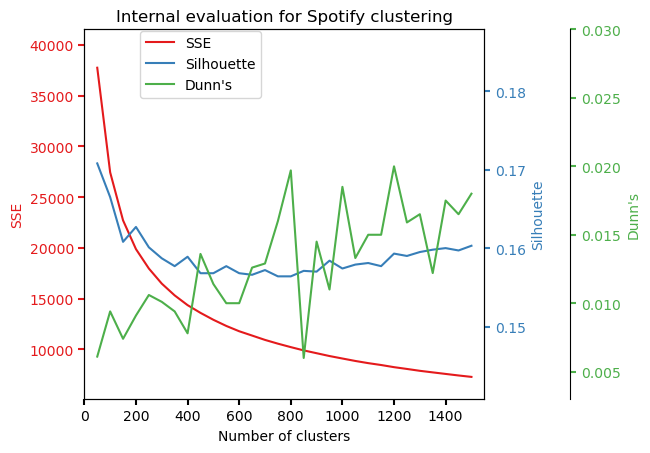

In [35]:
#https://colorbrewer2.org/?type=qualitative&scheme=Set1&n=9
cols = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
k_values = range(50,1550,50)
kmeans_inertia = eval_matrix['SSE']
silhouette = eval_matrix['Silhouette']
dunn = eval_matrix['Dunns']

plt.style.use("default")
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.215))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(k_values, kmeans_inertia, cols[0], label="SSE")
p2, = par1.plot(k_values, silhouette, cols[1], label="Silhouette")
p3, = par2.plot(k_values, dunn, cols[2], label="Dunn's")

host.set_xlim(0, 1550)

# Auto calculate y axises
ylow = min(eval_matrix['SSE'])*0.7
yhigh = max(eval_matrix['SSE'])*1.1
host.set_ylim(ylow, yhigh)

ylow = min(eval_matrix['Silhouette'])*0.9
yhigh = max(eval_matrix['Silhouette'])*1.1
par1.set_ylim(ylow, yhigh)

ylow = min(eval_matrix['Dunns'])*0.5
yhigh = max(eval_matrix['Dunns'])*1.5
par2.set_ylim(ylow, yhigh)

host.set_xlabel("Number of clusters")
host.set_ylabel("SSE")
par1.set_ylabel("Silhouette")
par2.set_ylabel("Dunn's")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines],loc=(.14,.815))

plt.title("Internal evaluation for Spotify clustering")
plt.show()

In [ ]:
##################################################
##         WARNING: THIS TAKES FOREVER          ##
##    ONLY run if data doesn't already exist.   ##
##    Otherwise, run the next block instead.    ##
##################################################

SEED=5523
kmeans_50 = KMeans(n_clusters=50,random_state=SEED).fit(train_pca)
kmeans_400 = KMeans(n_clusters=400,random_state=SEED).fit(train_pca)
kmeans_800 = KMeans(n_clusters=800,random_state=SEED).fit(train_pca)
kmeans_1200 = KMeans(n_clusters=1200,random_state=SEED).fit(train_pca)
kmeans_1500 = KMeans(n_clusters=1500,random_state=SEED).fit(train_pca)

various_k_models = pd.DataFrame(index=range(0,34442),data = {
    'K=50':kmeans_50.labels_,
    'K=400':kmeans_400.labels_,
    'K=800':kmeans_800.labels_,
    'K=1200':kmeans_1200.labels_,
    'K=1500':kmeans_1500.labels_
})
various_k_models = pd.concat([various_k_models, train_pca.reset_index(drop=True)], axis=1)
various_k_models.to_csv("./data_frames/various_k_models.csv")
various_k_models

In [14]:
###############################
##  Only run if data exists  ##
###############################

various_k_models = pd.read_csv("./data_frames/various_k_models.csv",usecols = range(1,11))
various_k_models

,K=50,K=400,K=800,K=1200,K=1500,PC1,PC2,PC3,PC4,PC5
0,29,61,255,222,1298,-1.754467,1.750825,-0.783555,-0.631788,0.484726
1,38,338,339,444,1204,-2.335419,0.748458,-0.089094,-0.561038,0.747956
2,29,399,336,499,1182,-1.263240,1.193045,-0.063982,-0.033998,0.071014
3,29,119,541,561,222,-1.310803,2.241439,-0.588734,-0.055600,0.299317
4,8,313,236,517,1279,-1.248762,1.315978,0.014835,1.099243,0.223407
...,...,...,...,...,...,...,...,...,...,...
34437,32,27,131,885,885,2.563366,1.719795,-0.135897,0.455785,-0.531072
34438,21,96,397,1104,1104,-0.429882,0.091292,0.435006,1.104856,-0.700108
34439,33,252,777,1129,1129,0.712116,-0.027654,0.560080,-0.316299,-0.141671
34440,31,108,147,883,883,2.229248,0.298709,0.460573,-0.537482,-0.797268


# Visualize datapoints

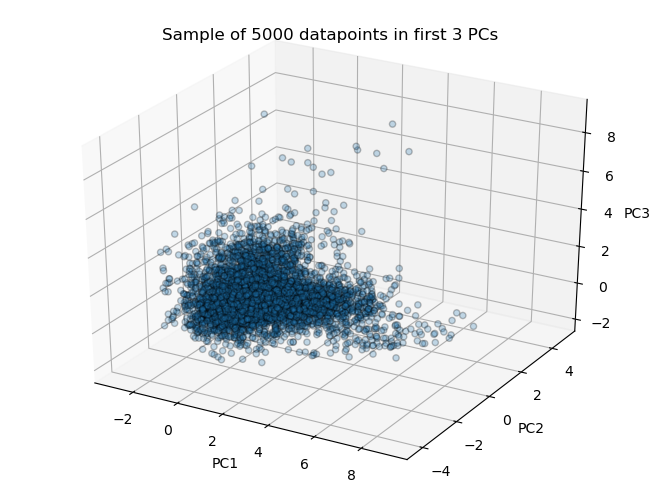

In [96]:
fig = plt.figure()
ax = Axes3D(fig)

n_sample = 5000
various_k_models_sample = various_k_models.sample(n_sample)

x = various_k_models_sample['PC1']
y = various_k_models_sample['PC2']
z = various_k_models_sample['PC3']

ax.scatter(
    x, y, z,
    s=20, marker='o', edgecolor='black',
    alpha=0.25
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f"Sample of {n_sample} datapoints in first 3 PCs")
plt.show()

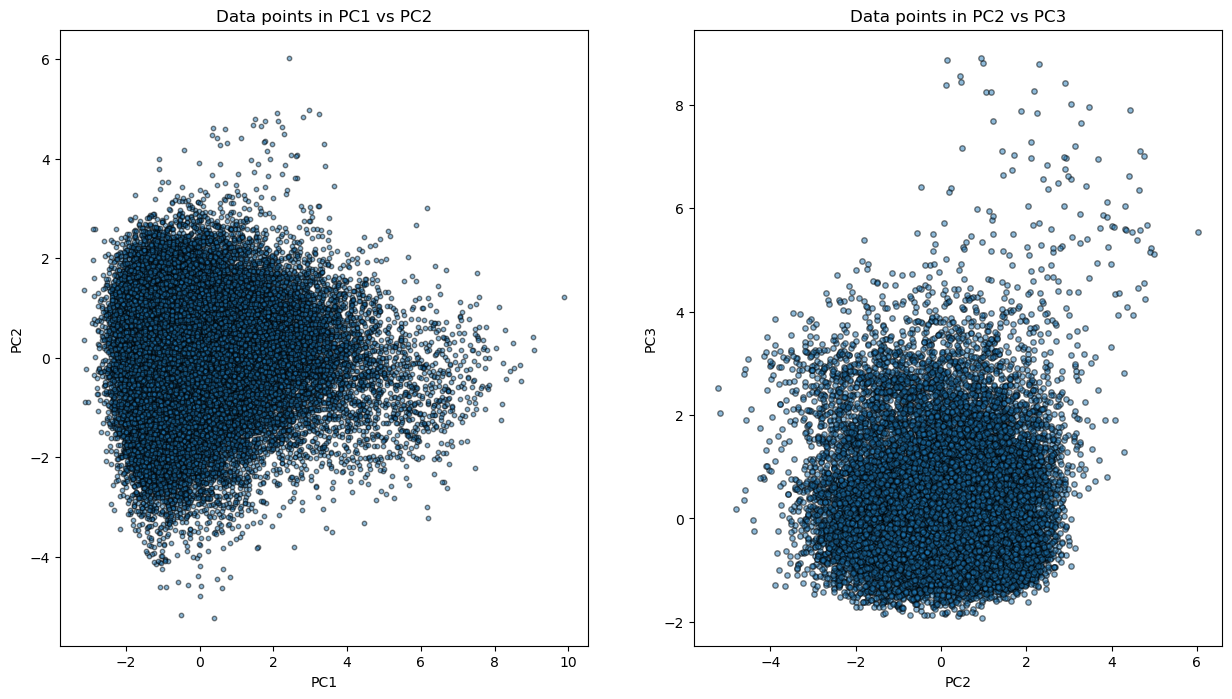

In [85]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.scatter(
    various_k_models['PC1'], 
    various_k_models['PC2'],
    s=10, marker='o', edgecolor='black',
    alpha=0.50
)

plt.title("Data points in PC1 vs PC2")
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1,2,2)
plt.scatter(
    various_k_models['PC2'], 
    various_k_models['PC3'],
    s=15, marker='o', edgecolor='black',
    alpha=0.50
)

plt.title("Data points in PC2 vs PC3")
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.show()

The majority of tracks have values in the ranges:
    
    PC1 = -2 to 6
    PC2 = -3 to 2
    PC3 = -2 to 3

which makes sense because PC is supposed to make up the most variance. We want to see this giant cluster partitioned into smaller clusters.

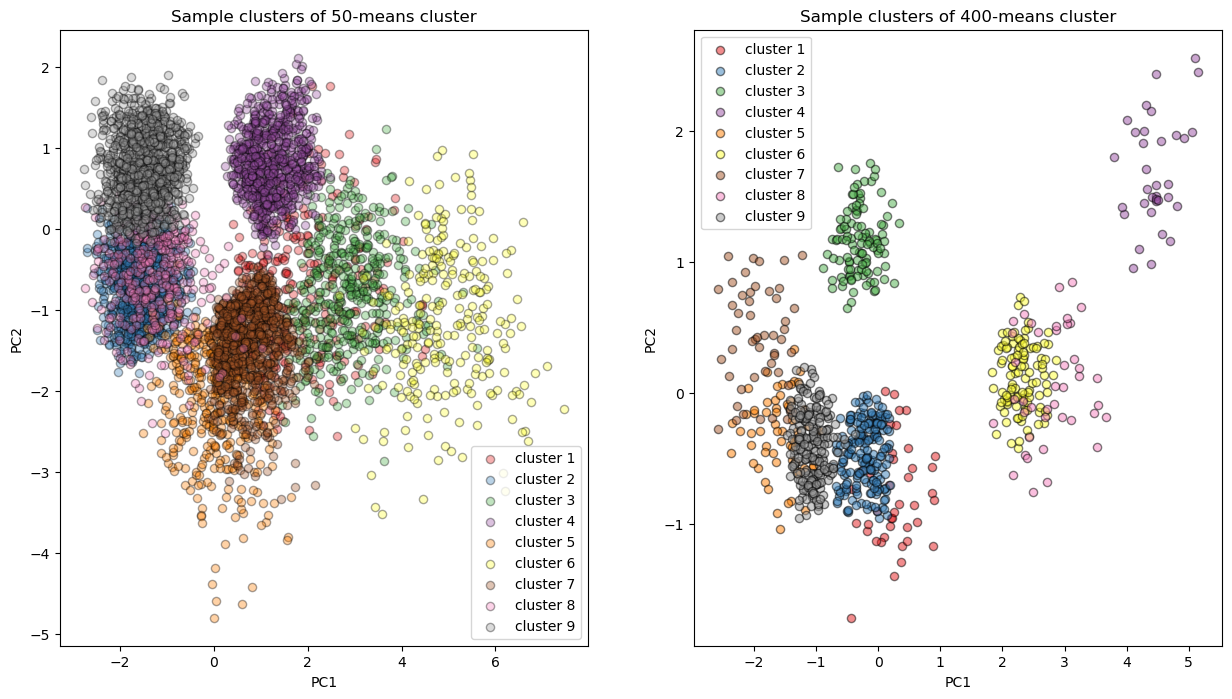

In [91]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
for i in range(9):
    plt.scatter(
        various_k_models[(various_k_models['K=50'] == i)]['PC1'], 
        various_k_models[(various_k_models['K=50'] == i)]['PC2'],
        s=35, c=cols[i],
        marker='o', edgecolor='black',
        label='cluster '+str(i+1),
        alpha=0.35
    )

plt.title("Sample clusters of 50-means cluster")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(scatterpoints=1)

plt.subplot(1,2,2)
for i in range(9):
    plt.scatter(
        various_k_models[(various_k_models['K=400'] == i)]['PC1'], 
        various_k_models[(various_k_models['K=400'] == i)]['PC2'],
        s=35, c=cols[i],
        marker='o', edgecolor='black',
        label='cluster '+str(i+1),
        alpha=0.50
    )

plt.title("Sample clusters of 400-means cluster")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(scatterpoints=1)

plt.show()

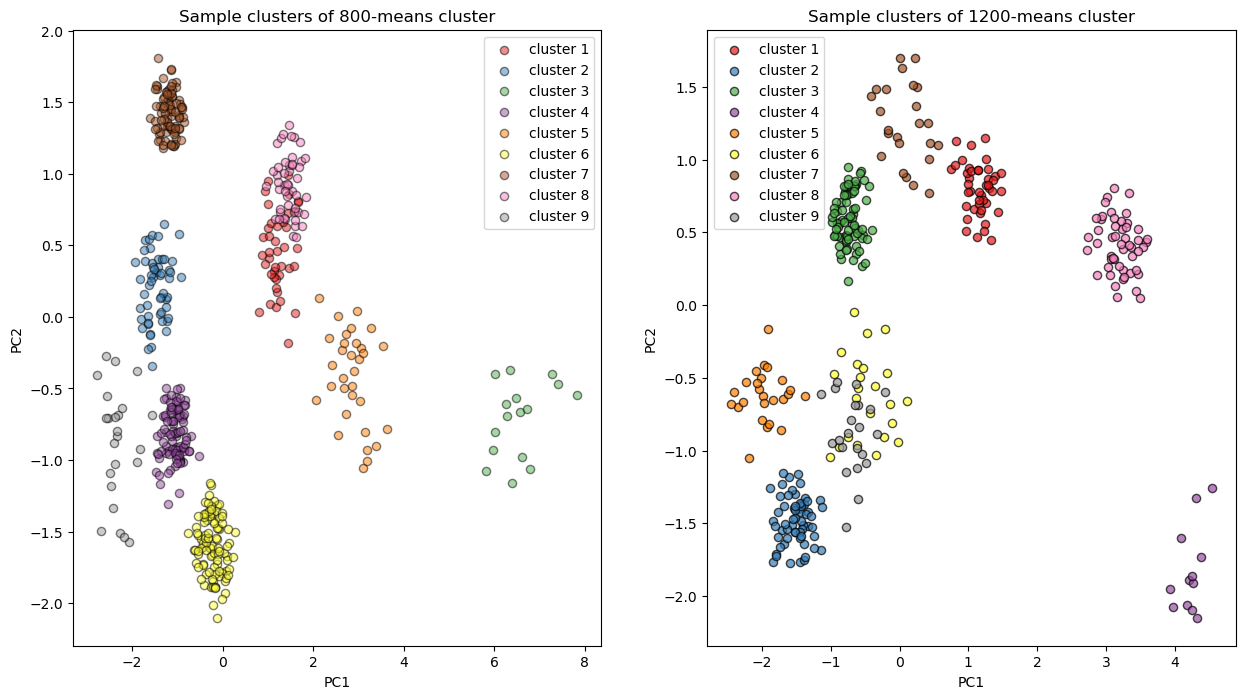

In [89]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
for i in range(9):
    plt.scatter(
        various_k_models[(various_k_models['K=800'] == i)]['PC1'], 
        various_k_models[(various_k_models['K=800'] == i)]['PC2'],
        s=35, c=cols[i],
        marker='o', edgecolor='black',
        label='cluster '+str(i+1),
        alpha=0.50
    )

plt.title("Sample clusters of 800-means cluster")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(scatterpoints=1)

plt.subplot(1,2,2)
for i in range(9):
    plt.scatter(
        various_k_models[(various_k_models['K=1200'] == i)]['PC1'], 
        various_k_models[(various_k_models['K=1200'] == i)]['PC2'],
        s=35, c=cols[i],
        marker='o', edgecolor='black',
        label='cluster '+str(i+1),
        alpha=0.70
    )

plt.title("Sample clusters of 1200-means cluster")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(scatterpoints=1)

plt.show()